In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

In [3]:
!pip install pydicom
!pip install scikit-image
import pydicom
import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc,ndimage
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:00


In [4]:
train_data_dir = '/content/drive/MyDrive/Brain Tumor Data/Train'
validation_data_dir = '/content/drive/MyDrive/Brain Tumor Data/Validation'

In [5]:
img_width, img_height = 299, 299
train_samples, validation_samples, epochs, batch_size = 98, 14, 20, 5

In [6]:
# 1st Augmentation: Normalize the data
# 2nd Augmentation: Set a shear range, zoom range, rotation range, width/height range to 0.2
# 3rd Augmentation: Flip images horiztonally
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True
)

# Normalize the data
val_datagen = ImageDataGenerator(
    rescale = 1./255
)

# Load data and perform augmentation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 98 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


In [7]:
# Built the neural network
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None)),
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

model.compile(optimizer=Adam(learning_rate=0.00003, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 1s 0us/step


In [8]:
# Train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_samples / batch_size,
    epochs = epochs,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = validation_samples / batch_size
)

<ipython-input-8-34d2b882f441>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
19/19 [==============================] - 135s 6s/step - loss: 0.6322 - accuracy: 0.6633 - val_loss: 0.5574 - val_accuracy: 0.7143
Epoch 2/20
19/19 [==============================] - 104s 5s/step - loss: 0.3005 - accuracy: 0.9490 - val_loss: 0.4264 - val_accuracy: 1.0000
Epoch 3/20
19/19 [==============================] - 107s 5s/step - loss: 0.2069 - accuracy: 0.9592 - val_loss: 0.3079 - val_accuracy: 1.0000
Epoch 4/20
19/19 [==============================] - 111s 6s/step - loss: 0.2509 - accuracy: 0.9184 - val_loss: 0.2139 - val_accuracy: 1.0000
Epoch 5/20
19/19 [==============================] - 107s 5s/step - loss: 0.1698 - accuracy: 0.9286 - val_loss: 0.1229 - val_accuracy: 1.0000
Epoch 6/20
19/19 [==============================] - 107s 6s/step - loss: 0.1740 - accuracy: 0.9388 - val_loss: 0.0972 - val_accuracy: 1.0000
Epoch 7/20
19/19 [==============================] - 107s 6s/step - loss: 0.1057 - accuracy: 0.9694 - val_loss: 0.0818 - val_accuracy: 1.0000
Epoch 8/20
19

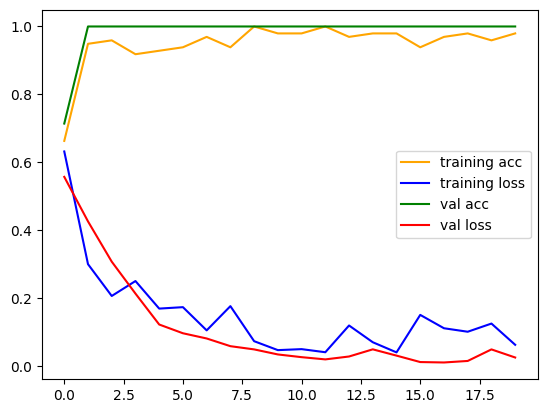

<Figure size 640x480 with 0 Axes>

In [9]:
import pandas as pd

# Plot the training accuracy, training loss, validation accuracy, and validation loss
plt.figure()
plt.plot(history.history['accuracy'], color = 'orange', label = 'training acc')
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_accuracy'], color = 'green', label = 'val acc')
plt.plot(history.history['val_loss'], color = 'red', label = 'val loss')
plt.legend()
plt.show()

# Save the results to Google Drive
RESULT_DIR = '/content/drive/MyDrive/Brain Tumor Data'
save_name = 'history-TumorClassification.png'
plt.savefig(os.path.join(RESULT_DIR,save_name))

hist_df = pd.DataFrame(history.history)
hist_csv_file = os.path.join(RESULT_DIR,'history_1.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [10]:
from PIL import Image
from numpy import asarray

test_data_dir = '/content/drive/MyDrive/Brain Tumor Data/Test'

right = 0
wrong = 0

for image in os.listdir(test_data_dir):
  print(image)
  if (image.endswith("jpg")):
    # Read image, reduce noise, resize
    img = cv2.imread(os.path.join(test_data_dir,image))
    img = cv2.resize(img, (img_width, img_height))
    img = np.asarray(img)
    # Print image and prediction
    x = np.expand_dims(img, axis=0) * 1./255
    score = model.predict(x)
    print('Predicted:', score, 'Cancer' if score < 0.5 else 'Not Cancer')
    print()
    if ((score < 0.5 and img[0:1] == 'N') or (score >= 0.5 and img[0:1] == 'C')):
      wrong += 1
    else:
      right += 1

Cancer (517).jpg
1/1 [==============================] - 2s 2s/step
Predicted: [[0.1276791]] Cancer

Cancer (519).jpg


<ipython-input-10-31dc48d91a80>:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ((score < 0.5 and img[0:1] == 'N') or (score >= 0.5 and img[0:1] == 'C')):


1/1 [==============================] - 0s 229ms/step
Predicted: [[0.00707594]] Cancer

Cancer (518).jpg
1/1 [==============================] - 0s 227ms/step
Predicted: [[0.0034466]] Cancer

Cancer (520).jpg
1/1 [==============================] - 0s 232ms/step
Predicted: [[0.00678534]] Cancer

Cancer (524).jpg
1/1 [==============================] - 0s 228ms/step
Predicted: [[0.00384574]] Cancer

Cancer (522).jpg
1/1 [==============================] - 0s 259ms/step
Predicted: [[0.00012494]] Cancer

Cancer (516).jpg
1/1 [==============================] - 0s 250ms/step
Predicted: [[0.00053549]] Cancer

Cancer (521).jpg
1/1 [==============================] - 0s 236ms/step
Predicted: [[0.00130702]] Cancer

Cancer (523).jpg
1/1 [==============================] - 0s 233ms/step
Predicted: [[0.00163336]] Cancer

Cancer (515).jpg
1/1 [==============================] - 0s 229ms/step
Predicted: [[0.00270803]] Cancer

Cancer (610).jpg
1/1 [==============================] - 0s 249ms/step
Predicted: [

% of Correct Predictions: 100.0


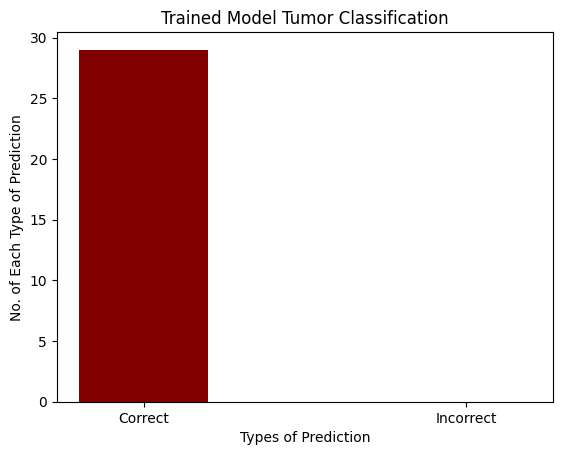

In [11]:
# Creating a bar chart to display the model's accuracy on test data
possibilities = ["Correct", "Incorrect"]
values = [right, wrong]
plt.bar(possibilities, values, color ='maroon', width = 0.4)
plt.xlabel("Types of Prediction")
plt.ylabel("No. of Each Type of Prediction")
plt.title("Trained Model Tumor Classification")

print("% of Correct Predictions:", (right/(right+wrong)*100))